In [ ]:
import glob
import numpy as np 
import time
import math
import random
from scipy import linalg as LA
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import NuSVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Importing files from google drive

---

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/go_track_tracks.csv')[:5]

,id,id_android,speed,time,distance,rating,rating_bus,rating_weather,car_or_bus,linha
0,1,0,19.210586,0.138049,2.652,3,0,0,1,NaN
1,2,0,30.848229,0.171485,5.290,3,0,0,1,NaN
2,3,1,13.560101,0.067699,0.918,3,0,0,2,NaN
3,4,1,19.766679,0.389544,7.700,3,0,0,2,NaN
4,8,0,25.807401,0.154801,3.995,2,0,0,1,NaN


# Importing data from my computer

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving go_track_tracks.csv to go_track_tracks.csv
Saving go_track_trackspoints.csv to go_track_trackspoints.csv


In [ ]:
pd.read_csv("go_track_trackspoints.csv")[:5]

,id,latitude,longitude,track_id,time
0,1,-10.939341,-37.062742,1,2014-09-13 07:24:32
1,2,-10.939341,-37.062742,1,2014-09-13 07:24:37
2,3,-10.939324,-37.062765,1,2014-09-13 07:24:42
3,4,-10.939211,-37.062843,1,2014-09-13 07:24:47
4,5,-10.938939,-37.062879,1,2014-09-13 07:24:53


# Start of my code

In [ ]:
def read_file(file_name):
    data = []
    with open(file_name, "r") as f:
        for line in f:
            item = line.strip().split(",")
            data.append(np.array(item))
    return np.array(data)

In [ ]:
data1 = read_file('go_track_tracks.csv')[1:,:-1]
data2 = read_file('go_track_trackspoints.csv')[1:,1:4]

In [ ]:
float1 = np.vectorize(float)
int1 = np.vectorize(int)
track_id = int1(data1[:,0])
labels = np.where(int1(data1[:,-1]) < 1.5, int1(data1[:,-1]), -1) 
traj = float1(data2)

In [ ]:
trajec = [0] * 163

for i in range(163):
    trajec[i] = []
    I = np.where(traj[:,2] == track_id[i])
    trajec[i] = np.array([labels[i], traj[I]])

trajec = np.array(trajec)

In [ ]:
trajectory = [0] * 163
trajectory_label_id = [0] * 163

for i in range(163):
    trajectory[i] = trajec[i][1][:,:2]
    trajectory_label_id[i] = np.array([trajec[i][1][:,:2], trajec[i][0], trajec[i][1][:,2][0]])
    
trajectory_label_id = np.array(trajectory_label_id)
trajectory = np.array(trajectory)

In [ ]:
min_length = 10
max_length = 1000 
l = 0
index = [] 
for i in range(163):
    if len(trajectory[i]) < min_length or len(trajectory[i]) > max_length:
        l = l + 1
    else:
        index.append(i)
        
l, 163-l

(40, 123)

In [ ]:
trajectories = [0] * (163-l)
trajectories_label_id = [0] * (163-l)

j = 0
for i in range(163):
    if len(trajectory[i]) >= min_length and len(trajectory[i]) <= max_length:
        trajectories[j] = np.array(trajectory[i])
        trajectories_label_id[j] = trajectory_label_id[i]
        j = j + 1

trajectories_label_id = np.array(trajectories_label_id)
trajectories = np.array(trajectories)

In [ ]:
cars = trajectories_label_id[np.where(trajectories_label_id[:,1] == 1)][:,:2]
buses = trajectories_label_id[np.where(trajectories_label_id[:,1] == -1)][:,:2]

In [ ]:
num_cars = len(cars)
num_buses = len(buses)
num_cars_third = int(num_cars/3)
num_buses_third = int(num_buses/3)

R1 = random.sample(range(num_cars), num_cars_third)
R = np.sort(R1)
R_c = np.sort(list(set(range(num_cars)) - set(R)))
    
S1 = random.sample(range(num_buses), num_buses_third)
S = np.sort(S1)
S_c = np.sort(list(set(range(num_buses)) - set(S)))
    
train = np.insert(cars[R_c], len(cars[R_c]), buses[S_c], axis = 0)
test = np.insert(cars[R], len(cars[R]), buses[S], axis = 0)

train = list(train)
test = list(test)
random.shuffle(train)
random.shuffle(test)
train = np.array(train)
test = np.array(test)

In [ ]:
# creating box boundaries for landmark points for whole dataset

a1 = min([min(trajectories[i][:,0]) for i in range(len(trajectories))])
b1 = max([max(trajectories[i][:,0]) for i in range(len(trajectories))])
a2 = min([min(trajectories[i][:,1]) for i in range(len(trajectories))])
b2 = max([max(trajectories[i][:,1]) for i in range(len(trajectories))])

I = [np.mean(trajectories[i][:,0]) for i in range(len(trajectories))]
J = [np.mean(trajectories[i][:,1]) for i in range(len(trajectories))]
m1 = np.mean(I)
m2 = np.mean(J)
M1 = np.median(I)
M2 = np.median(J)
V1 = np.var(I)
V2 = np.var(J)
std_x = np.std(I)
std_y = np.std(J)

print("x-coordinate minimum is: ", a1)
print("x-coordinate maximum is: ", b1) 
print("x-coordinate mean is: ", m1)
print("x-coordinate median is: ", M1)
print("x-coordinate variance is: ", V1)
print("x-coordinate standard deviation is: ", std_x, '\n')

print("y-coordinate minimum is: ", a2) 
print("y-coordinate maximun is: ", b2)
print("y-coordinate mean is: ", m2)
print("y-coordinate median is: ", M2)
print("y-coordinate variance is: ", V2)
print("y-coordinate standard deviation is: ", std_y)

x-coordinate minimum is:  -27.34482954
x-coordinate maximum is:  -10.34829445
x-coordinate mean is:  -11.186044740676428
x-coordinate median is:  -10.922770832754491
x-coordinate variance is:  4.304589737933851
x-coordinate standard deviation is:  2.074750524264026 

y-coordinate minimum is:  -48.63291841
y-coordinate maximun is:  -36.49335713
y-coordinate mean is:  -37.24448358617738
y-coordinate median is:  -37.06077748113637
y-coordinate variance is:  2.1450068941275773
y-coordinate standard deviation is:  1.4645842052021376


# Creating m random landmarks

In [ ]:
m = 20
Q = np.ones((m,2))

mu_x = -11.186
sigma_x = 2.1
Q[:,0] = np.random.normal(mu_x, sigma_x, m)

mu_y = -37.244
sigma_y = 1.46
Q[:,1] = np.random.normal(mu_y, sigma_y, m)

In [ ]:
df = pd.DataFrame(data={"col1": Q[:,0], "col2": Q[:,1]})
df.to_csv("Q.csv", sep=',',index=False)
np.savetxt('/content/gdrive/My Drive/Research/Car-Bus/Q_Nov_23.csv', Q, delimiter=',')

In [ ]:
# Random Q of size 20 on November 23
Q = np.array([[-11.51839252, -36.00167761],
       [-13.82387038, -41.06091863],
       [ -5.52315713, -37.39424807],
       [-11.307905  , -37.68847429],
       [-13.34456129, -36.62837387],
       [-11.25127849, -38.96427889],
       [ -9.70920127, -37.70032869],
       [-10.84289516, -36.12955072],
       [-13.29665413, -37.43363195],
       [ -9.06848519, -37.87890405],
       [-11.1337595 , -36.73167919],
       [-11.15004646, -37.94099833],
       [-11.76909718, -33.96734203],
       [-11.29377414, -40.15240307],
       [-11.38400841, -37.02645598],
       [-10.64689404, -37.77147543],
       [-11.20407876, -36.41339879],
       [ -9.16302112, -37.81380282],
       [-12.87662174, -38.41711695],
       [-12.27654292, -38.37274434]])

# Our Feature Map

In [ ]:
def fun(x):
    if x >= 1: 
        y = 0
    elif x <= -1:
        y = math.pi
    else: 
        y = np.arccos(x)
    return y

In [ ]:
def dist_signed_point_closed(Q, gamma, sigma): 
    
    h = 10e-8
    p1 = gamma[:-1]
    p2 = gamma[1:]
    L = np.sqrt(((p2-p1)*(p2-p1)).sum(axis =1))
    II = np.where(L > h)[0]
    p1 = p1[II]
    p2 = p2[II]
    gamma = np.array(list(p1) + [p2[-1]])
    L = np.sqrt(((p2-p1)*(p2-p1)).sum(axis =1)) + h
    
    w = (p1-p2)*(-1,1)/(L * np.ones((2,1))).T
    w[:,[0, 1]] = w[:,[1, 0]]
    
# signed distance to the extended lines of segments
    dist_signed = np.sum(w * (Q.reshape(len(Q),1,2) - p1), axis=2)
    x = dist_signed + 0
    R = (L**2).reshape(-1,1)
# u = argmin points on the extended lines of segments
    u = p1 + ((((np.sum(((Q.reshape(len(Q),1,2) - p1) * (p2 - p1)),axis=2).reshape(len(Q)
                ,-1,1,1) * (p2-p1).reshape(len(p2-p1),1,2))).reshape(len(Q),len(p1),2))/R)

    G = np.sqrt(np.sum((u-p1)*(u-p1), axis=2))
    H = np.sqrt(np.sum((u-p2)*(u-p2), axis=2))
# d1 = distance to start points
    d1 = np.sqrt(np.sum((Q.reshape(len(Q),1,2)-p1)*(Q.reshape(len(Q),1,2)-p1), axis=2))
# d2 = distance to end points
    d2 = np.sqrt(np.sum((Q.reshape(len(Q),1,2)-p2)*(Q.reshape(len(Q),1,2)-p2), axis=2))
    d = np.where(d1 < d2, d1, d2)
    dist_segment = np.where(abs(G + H - L) < np.ones(len(L)) * h, dist_signed, d)
    
    J2 = [0] * len(Q)
    for i in range(len(Q)): 
        J2[i] = np.where(abs(G + H - L)[i] > h)[0]
    J2 = np.array(J2)

    dist_segment_copy = dist_segment.copy()
    dist = abs(dist_segment_copy)


    j = np.argmin(dist, axis =1)

    sign = np.ones(len(Q))
    for k in range(len(Q)): 
        if j[k] in J2[k]:
            if j[k] == 0 and LA.norm(Q[k] - gamma[0]) < LA.norm(Q[k] - gamma[1]):
                
                y = LA.norm(gamma[0]-gamma[1]) - LA.norm(gamma[-1] - gamma[-2])
                if y < 0:
                    x = gamma[0] + 0.1 * LA.norm(gamma[0]-gamma[1])*(gamma[-2]-gamma[-1])/LA.norm(gamma[-2]-gamma[-1])
                    z = gamma[0] + 0.1 * LA.norm(gamma[0]-gamma[1])*(gamma[1]-gamma[0])/LA.norm(gamma[1]-gamma[0])
                    q = 2 * gamma[0] - (x + z)/2
                else: 
                    x = gamma[0] + 0.1 * LA.norm(gamma[-1]-gamma[-2])*(gamma[1]-gamma[0])
                    z = gamma[0] + 0.1 * LA.norm(gamma[-1]-gamma[-2])*(gamma[-2]-gamma[-1])
                    q = 2 * gamma[0] - (x + z)/2
                sign[k] = np.sign((q-gamma[-1]).dot(w[-1] + w[0]))
                
            elif j[k] == len(gamma)-2 and LA.norm(Q[k] - gamma[-1]) < LA.norm(Q[k] - gamma[-2]):
                s = w[-1].dot((Q[k] - gamma[-1])/ LA.norm(Q[k] - gamma[-1]) + h)
                sign[k] = np.sign(s)
            
            elif LA.norm(Q[k] - gamma[j[k]]) < LA.norm(Q[k] - gamma[j[k]+1]):  
                q = 2 * gamma[j[k]] - (gamma[j[k]-1] + gamma[j[k]+1])/2
                sign[k] = np.sign((q-gamma[j[k]]).dot(w[j[k]-1] + w[j[k]]))
                    
            elif LA.norm(Q[k] - gamma[j[k]+1]) <= LA.norm(Q[k] - gamma[j[k]]):
                q = 2 * gamma[j[k]+1] - (gamma[j[k]] + gamma[j[k]+2])/2
                sign[k] = np.sign((q-gamma[j[k]+1]).dot(w[j[k]] + w[j[k]+1]))

    E = dist_segment[np.arange(len(dist_segment)),j] 
    F = dist[np.arange(len(dist)),j] 
    dist_weighted = (1/sigma) * sign * (E.reshape(-1,1) * np.exp(-(F/sigma)**2).reshape(-1,1)).reshape(1,-1)

    
    u1 = u[np.arange(len(u)),j]
    p11 = p1[j]
    p22 = p2[j]
    
    L1 = np.sqrt(((p22-p11)*(p22-p11)).sum(axis =1)) + h
    G1 = np.sqrt(np.sum((u1-p11)*(u1-p11), axis=1))
    H1 = np.sqrt(np.sum((u1-p22)*(u1-p22), axis=1))
    I1 = np.where(abs(G1 + H1 - L1) < np.ones(len(L1)) * h)[0]

# d11 = distance to start points
    d11 = np.sqrt(np.sum((Q-p11)*(Q-p11), axis=1)) #np.sqrt(np.sum((Q.reshape(len(Q),1,2)-p11)*(Q.reshape(len(Q),1,2)-p11), axis=2))
# d22 = distance to end points
    d22 = np.sqrt(np.sum((Q-p22)*(Q-p22), axis=1)) #np.sqrt(np.sum((Q.reshape(len(Q),1,2)-p22)*(Q.reshape(len(Q),1,2)-p22), axis=2))
    dd = np.where(d11 < d22)[0]

    u_argmin = [0] * len(Q)
    for i in range(len(Q)):
        if len(I1)>0: 
            if i in I1:
                u_argmin[i] = u1[i]
        elif len(dd)>0: 
            if i in dd:
                u_argmin[i] = p1[i]
        else:
            u_argmin[i] = p2[i]
            
    u_argmin = np.array(u_argmin)
    sign_correct = np.where(np.sign(dist_weighted) == 0, 1, np.sign(dist_weighted))

    L2 = (np.sqrt(((Q - u_argmin)*(Q - u_argmin)).sum(axis =1)) + h).reshape(-1,1)
    n_p_q = sign_correct.reshape(-1,1) * (Q - u_argmin)/L2
    dot_n_p_q = (sign_correct.reshape(-1,1) * L2).reshape(len(Q))
    dot_n_p_q_times_q_p = ((n_p_q * (Q - u_argmin)).sum(axis=1)).reshape(-1,1) * (Q -u_argmin)

    return dist_weighted.reshape(len(Q)), n_p_q, dot_n_p_q_times_q_p, L2.reshape(len(Q))


In [ ]:
def dist_signed_point_unclosed(Q, gamma, sigma): 
    
    h = 10e-8
    p1 = gamma[:-1]
    p2 = gamma[1:]
    L = np.sqrt(((p2-p1)*(p2-p1)).sum(axis =1)) 
    II = np.where(L > h)[0]
    p1 = p1[II]
    p2 = p2[II]
    gamma = np.array(list(p1) + [p2[-1]]) # or use concatination 
    L = np.sqrt(((p2-p1)*(p2-p1)).sum(axis =1)) + h
    w = (p1-p2)*(-1,1)/(L * np.ones((2,1))).T
    w[:,[0, 1]] = w[:,[1, 0]]
    
# signed distance to the extended lines of segments
    dist_signed = np.sum(w * (Q.reshape(len(Q),1,2) - p1), axis=2)
    b = dist_signed + 0
    x = abs(b)
    R = (L**2).reshape(-1,1)

# u = argmin points on the extended lines of segments
    u = p1 + ((((np.sum(((Q.reshape(len(Q),1,2) - p1) * (p2 - p1)),axis=2).reshape(len(Q)
                ,-1,1,1) * (p2-p1).reshape(len(p2-p1),1,2))).reshape(len(Q),len(p1),2))/R)

    G = np.sqrt(np.sum((u-p1)*(u-p1), axis=2))
    H = np.sqrt(np.sum((u-p2)*(u-p2), axis=2))
# d1 = distance to start points
    d1 = np.sqrt(np.sum((Q.reshape(len(Q),1,2)-p1)*(Q.reshape(len(Q),1,2)-p1), axis=2))
# d2 = distance to end points
    d2 = np.sqrt(np.sum((Q.reshape(len(Q),1,2)-p2)*(Q.reshape(len(Q),1,2)-p2), axis=2))
    d = np.where(d1 < d2, d1, d2)

    dist_segment = np.where(abs(G + H - L) < np.ones(len(L)) * 2*h, dist_signed, d)

    J2 = [0] * len(Q)
    for i in range(len(Q)): 
        J2[i] = np.where(abs(G + H - L)[i] > 2 * h)[0]
    J2 = np.array(J2)
    
    dist_segment_copy = dist_segment + 0
    dist = abs(dist_segment_copy)
    
    dist_from_start_1 = np.sqrt(((Q -p1[0])*(Q -p1[0])).sum(axis =1))
    ds_1 = ((Q -p1[0])*w[0]).sum(axis =1)
    dist_from_start = ds_1 * np.maximum(abs(ds_1), np.sqrt(dist_from_start_1**2 - ds_1**2 + 
                                                        h))/ (dist_from_start_1 + h)

    dist_from_end_1 = np.sqrt(((Q -p2[-1])*(Q -p2[-1])).sum(axis =1))
    de_1 = ((Q -p2[-1])* w[-1]).sum(axis =1)
    dist_from_end = de_1 * np.maximum(abs(de_1), np.sqrt(dist_from_end_1**2 - 
                                                de_1**2 + h))/ (dist_from_end_1+ h)

    dist_segment[:,0] = np.where(abs(dist[:,0]- dist_from_start_1)< h, 
                                 dist_from_start, dist_segment[:,0]) 

    dist_segment[:,-1] = np.where(abs(dist[:,-1]- dist_from_end_1)< h, 
                                  dist_from_end, dist_segment[:,-1]) 

    j = np.argmin(dist, axis =1)

    sign = np.ones(len(Q))
    for k in range(len(Q)): 
        if j[k] in J2[k]: 
            if j[k] == 0 and LA.norm(Q[k] - gamma[0]) < LA.norm(Q[k] - gamma[1]):
                sign[k] = 1
                
            elif j[k] == len(gamma)-2 and LA.norm(Q[k] - gamma[j[k]+1]) < LA.norm(Q[k] - 
                                                                            gamma[j[k]]):
                sign[k] = 1
            
            elif LA.norm(Q[k] - gamma[j[k]]) < LA.norm(Q[k] - gamma[j[k]+1]):  
                q = 2 * gamma[j[k]] - (gamma[j[k]-1] + gamma[j[k]+1])/2
                sign[k] = np.sign((q-gamma[j[k]]).dot(w[j[k]-1] + w[j[k]]))
                    
            elif LA.norm(Q[k] - gamma[j[k]+1]) <= LA.norm(Q[k] - gamma[j[k]]):
                q = 2 * gamma[j[k]+1] - (gamma[j[k]] + gamma[j[k]+2])/2
                sign[k] = np.sign((q-gamma[j[k]+1]).dot(w[j[k]] + w[j[k]+1]))
    
    E = dist_segment[np.arange(len(dist_segment)),j] 
    F = dist[np.arange(len(dist)),j] 
    dist_weighted = (1/sigma) * sign * (E.reshape(-1,1) *
                        np.exp(-(F/sigma)**2).reshape(-1,1)).reshape(1,-1)

    p11 = p1[j]
    p22 = p2[j]
    u1 = u[np.arange(len(u)),j]
    
    L1 = np.sqrt(((p22-p11)*(p22-p11)).sum(axis =1)) + h
    G1 = np.sqrt(np.sum((u1-p11)*(u1-p11), axis=1))
    H1 = np.sqrt(np.sum((u1-p22)*(u1-p22), axis=1))
    I1 = np.where(abs(G1 + H1 - L1) < np.ones(len(L1)) * h)[0]

# d11 = distance to start points
    d11 = np.sqrt(np.sum((Q-p11)*(Q-p11), axis=1)) 
    d22 = np.sqrt(np.sum((Q-p22)*(Q-p22), axis=1)) 
    dd = np.where(d11 < d22)[0]
    
    u_argmin = [0] * len(Q)

    for i in range(len(Q)):
        if len(I1)>0: 
            if i in I1:
                u_argmin[i] = u1[i]
            elif len(dd)>0: 
                if i in dd:
                    u_argmin[i] = p11[i]
                else:
                    u_argmin[i] = p22[i]
            else:
                u_argmin[i] = p22[i]    
                
        elif len(dd)>0: 
            if i in dd:
                u_argmin[i] = p11[i]
            else:
                u_argmin[i] = p22[i]
        else:
            u_argmin[i] = p22[i]

    u_argmin = np.array(u_argmin)
    
    sign_correct = np.where(np.sign(dist_weighted) == 0, 1, np.sign(dist_weighted))

    L2 = (np.sqrt(((Q - u_argmin)*(Q - u_argmin)).sum(axis =1)) + h).reshape(-1,1)
    n_p_q = sign_correct.reshape(-1,1) * (Q - u_argmin)/L2

    dot_n_p_q_times_q_p = (sign_correct.reshape(-1,1) * L2) * (Q - u_argmin)

    return dist_weighted.reshape(len(Q)), n_p_q, dot_n_p_q_times_q_p, L2.reshape(len(Q))

In [ ]:
def dist_signed_point(Q, gamma, sigma):
    
    if LA.norm(gamma[0]-gamma[-1]) > 10e-6:
        A = dist_signed_point_unclosed(Q, gamma, sigma)
    else: 
        A = dist_signed_point_closed(Q, gamma, sigma)
        
    return A

In [ ]:
sigma = 0.1 #1000

In [ ]:
projected_cars = [0] * num_cars # in R^20
projected_buses = [0] * num_buses # in R^20

Start_time = time.time()

for i in range(num_cars):
    projected_cars[i] = np.concatenate((dist_signed_point(Q,cars[i][0],sigma)[0],[1]), axis = 0)

for i in range(num_buses):
    projected_buses[i] = np.concatenate((dist_signed_point(Q,buses[i][0],sigma)[0],[-1]), axis = 0)
    
projected_cars = np.array(projected_cars)
projected_buses = np.array(projected_buses)

print('total time =', time.time() - Start_time)

total time = 0.4367692470550537


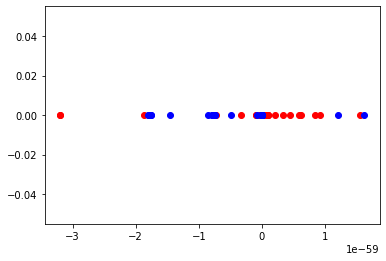

In [ ]:
x = projected_cars[:,0]
y = projected_cars[:,1]

u = projected_buses[:,0]
v = projected_buses[:,1]

plt.scatter(x, y, color= 'red')
plt.scatter(u, v, color= 'blue')
plt.show()

# Classifiers

In [ ]:
clf0 = KNeighborsClassifier(n_neighbors=5)
clf1 = svm.SVC(kernel='linear')
clf2 = make_pipeline(StandardScaler(), svm.SVC(C= 10000, kernel = 'rbf', gamma= 'auto', max_iter = 200000))
clf3 = make_pipeline(StandardScaler(), svm.SVC(C= 1000, kernel = 'rbf', gamma= 'auto', max_iter = 200000))
clf4 = make_pipeline(StandardScaler(), svm.SVC(C= 100, kernel = 'rbf', gamma= 'auto', max_iter = 200000))
clf5 = make_pipeline(StandardScaler(), svm.SVC(C=10000, kernel = 'poly', degree =3, max_iter = 400000))
clf6 = make_pipeline(StandardScaler(), svm.SVC(C=10000, kernel = 'poly', degree =2, max_iter = 400000))
clf7 = DecisionTreeClassifier()
clf8 = DecisionTreeClassifier(max_depth= 4)
clf9 = DecisionTreeClassifier(max_depth= 5)
clf10 = RandomForestClassifier(n_estimators=100)
clf11 = RandomForestClassifier(n_estimators=100, max_depth=5)
clf12 = RandomForestClassifier(n_estimators=100, max_depth=6)
clf13 = RandomForestClassifier(n_estimators=100, max_depth=7)
clf14 = RandomForestClassifier(n_estimators=100, criterion='entropy')
clf15 = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=5)
clf16 = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=6)
clf17 = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=7)
clf18 = AdaBoostClassifier(n_estimators= 100)
clf19 = AdaBoostClassifier(n_estimators= 100,learning_rate=0.8)
clf20 = AdaBoostClassifier(n_estimators= 100,learning_rate=1.1)

clf = [clf0,clf1,clf2,clf3,clf4,clf5,clf6,clf7,clf8,clf9,clf10,clf11,clf12,
       clf13,clf14,clf15,clf16,clf17,clf18,clf19,clf20]

In [ ]:
Start_time = time.time()

X_1 = projected_cars
X_2 = projected_buses

t = 1000

error_train = np.zeros((len(clf), t))
error_test = np.zeros((len(clf), t))

for i in range(t): 

    R1 = random.sample(range(78), 23)
    R = np.sort(R1)
    R_c = np.sort(list(set(range(78)) - set(R)))
    
    S1 = random.sample(range(45), 13)
    S = np.sort(S1)
    S_c = np.sort(list(set(range(45)) - set(S)))
    
    data_train = np.insert(X_1[R_c], len(X_1[R_c]), X_2[S_c], axis = 0)
    data_test = np.insert(X_1[R], len(X_1[R]), X_2[S], axis = 0)    
    
    data_train = list(data_train)
    data_test = list(data_test)
    random.shuffle(data_train)
    random.shuffle(data_test)
    data_train = np.array(data_train)
    data_test = np.array(data_test)
    
    for k in range(len(clf)):
        
        model = clf[k]
        #Train the model using the training sets
        model.fit(data_train[:,:-1], data_train[:,-1])

        #Predict the response for test dataset
        y_pred = model.predict(data_test[:,:-1])
        error_test[k][i] = 1 - metrics.accuracy_score(data_test[:,-1], y_pred)
        
        x_pred = model.predict(data_train[:,:-1])
        error_train[k][i] = 1 - metrics.accuracy_score(data_train[:,-1], x_pred)
    if i in [100,200,300,400,500,600,700,800,900]:
      print(i, "passed")    
print('total time =', time.time() - Start_time)

100 passed
200 passed
300 passed
400 passed
500 passed
600 passed
700 passed
800 passed
900 passed
total time = 31.458988428115845


In [ ]:
print("November 23,", '|Q|=20,', 'New distance,', 'sigma=', sigma,',', "t=", t)

Dic = {}

models = ["Gaussian SVM, C=1, gamma= auto", 
          "Gaussian SVM, C = 10, gamma = auto", "Gaussian SVM, C = 100, gamma = auto",
          "Poly kernel SVM, deg=3", "Poly kernel SVM, deg=2, C=100"]

for k in range(len(models)): 
    Dic[k+1] = [models[k], np.round(np.mean(error_train[k]), decimals = 4), 
                np.round(np.mean(error_test[k]), decimals = 4),
               np.round(np.std(error_test[k]), decimals = 4)]
    
pd.DataFrame.from_dict(Dic, orient='index', columns=['Classifier','Train Error', 'Test Error', 
                                                     'Standard Deviation'])

November 23, |Q|=20, New distance, sigma= 0.1 , t= 1000


,Classifier,Train Error,Test Error,Standard Deviation
1,"Gaussian SVM, C=1, gamma= auto",0.1039,0.2246,0.0588
2,"Gaussian SVM, C = 10, gamma = auto",0.1306,0.2301,0.0567
3,"Gaussian SVM, C = 100, gamma = auto",0.1432,0.2439,0.0565
4,"Poly kernel SVM, deg=3",0.1170,0.2453,0.0554
5,"Poly kernel SVM, deg=2, C=100",0.1197,0.2317,0.0587


In [ ]:
print("November 23,", '|Q|=20,', 'New distance,', 'sigma=', sigma,',', "t=", t)

Dic = {}

models = ["KNN", "Linear kernel SVM", "Gaussian SVM, C=1, gamma= auto", 
          "Gaussian SVM, C = 10, gamma = auto", "Gaussian SVM, C = 100, gamma = auto",
          "Poly kernel SVM, deg=3", "Poly kernel SVM, deg=2, C=100", 
          "Decision Tree", "Decision Tree, depth=4", "Decision Tree, depth=5",
          'RF, gini, 100 estimators', 
          'RF, gini, max_depth=5, 100 estimators',
          'RF, gini, max_depth=6, 100 estimators',
          'RF, gini, max_depth=7, 100 estimators', 
          'RF, entropy, 100 estimators',
          'RF, entropy, max_depth=5, 100 estimators',
          'RF, entropy, max_depth=6, 100 estimators', 
          'RF, entropy, max_depth=7, 100 estimators', 
          'AdaBoost, 100 estimators',
          'AdaBoost, learning rate=0.8, 100 estimators',
          'AdaBoost, learning rate=1.1, 100 estimators']

for k in range(len(models)): 
    Dic[k+1] = [models[k], np.round(np.mean(error_train[k]), decimals = 4), 
                np.round(np.mean(error_test[k]), decimals = 4),
               np.round(np.std(error_test[k]), decimals = 4)]
    
pd.DataFrame.from_dict(Dic, orient='index', columns=['Classifier','Train Error', 'Test Error', 
                                                     'Standard Deviation'])

November 23, |Q|=20, New distance, sigma= 1000 , t= 1000


,Classifier,Train Error,Test Error,Standard Deviation
1,KNN,0.2553,0.3866,0.0688
2,Linear kernel SVM,0.3678,0.3611,0.0000
3,"Gaussian SVM, C=1, gamma= auto",0.0000,0.2764,0.0732
4,"Gaussian SVM, C = 10, gamma = auto",0.0025,0.2827,0.0721
5,"Gaussian SVM, C = 100, gamma = auto",0.0372,0.2894,0.0719
6,"Poly kernel SVM, deg=3",0.0002,0.3994,0.0779
7,"Poly kernel SVM, deg=2, C=100",0.0004,0.3083,0.0751
8,Decision Tree,0.0000,0.2299,0.0715
9,"Decision Tree, depth=4",0.0829,0.2702,0.0697
10,"Decision Tree, depth=5",0.0443,0.2502,0.0706


#Old Distance

In [ ]:
def old_dist(Q, gamma):
    
    p2 = gamma[1:]
    p1 = gamma[:-1]
    L = np.sqrt(((p2-p1)*(p2-p1)).sum(axis =1))
    II = np.where(L>10e-8)[0]
    L = L[II]
    p1 = p1[II]
    p2 = p2[II]
    w = (p1-p2)*(-1,1)/(L*np.ones((2,1))).T
    w[:,[0, 1]] = w[:,[1, 0]]
    
    dist_dot = np.sum(w * (Q.reshape(len(Q),1,2) - p1), axis=2)
    
    x = abs(dist_dot.copy())
    R = (L**2).reshape(-1,1)
    u = p1 + ((((np.sum(((Q.reshape(len(Q),1,2) - p1) * (p2 - p1)),axis=2).reshape(len(Q)
                ,-1,1,1) * (p2-p1).reshape(len(p2-p1),1,2))).reshape(len(Q),len(p1),2))/R)
    
    G = np.sqrt(np.sum((u-p1)*(u-p1), axis=2))
    H = np.sqrt(np.sum((u-p2)*(u-p2), axis=2))
    d1 = np.sqrt(np.sum((Q.reshape(len(Q),1,2)-p1)*(Q.reshape(len(Q),1,2)-p1), axis=2))
    d2 = np.sqrt(np.sum((Q.reshape(len(Q),1,2)-p2)*(Q.reshape(len(Q),1,2)-p2), axis=2))

    dist = np.where(abs(G + H - L) < np.ones(len(L)) * (10e-8), x, np.minimum(d1, d2))

    j = np.argmin(dist, axis =1)
    dist_weighted = dist[np.arange(len(dist)),j]
    
    return dist_weighted.reshape(len(Q)) 

In [ ]:
projected_cars_old = [0] * num_cars # in R^20
projected_buses_old = [0] * num_buses # in R^20

Start_time = time.time()

for i in range(num_cars):
    projected_cars_old[i] = np.concatenate((old_dist(Q,cars[i][0]),[1]), axis = 0)

for i in range(num_buses):
    projected_buses_old[i] = np.concatenate((old_dist(Q,buses[i][0]),[-1]), axis = 0)
    
projected_cars_old = np.array(projected_cars)
projected_buses_old = np.array(projected_buses)

print('total time =', time.time() - Start_time)

total time = 0.11919474601745605


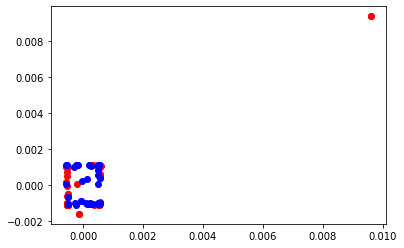

In [ ]:
x = projected_cars_old[:,0]
y = projected_cars_old[:,1]

u = projected_buses_old[:,0]
v = projected_buses_old[:,1]

plt.scatter(x, y, color= 'red')
plt.scatter(u, v, color= 'blue')
plt.show()

In [ ]:
X_11 = projected_cars_old
X_22 = projected_buses_old

Start_time = time.time()

t = 1000

error_train = np.zeros((len(clf), t))
error_test = np.zeros((len(clf), t))

for i in range(t): 

    R1 = random.sample(range(78), 23)
    R = np.sort(R1)
    R_c = np.sort(list(set(range(78)) - set(R)))
    
    S1 = random.sample(range(45), 13)
    S = np.sort(S1)
    S_c = np.sort(list(set(range(45)) - set(S)))
    
    data_train = np.insert(X_11[R_c], len(X_11[R_c]), X_22[S_c], axis = 0)
    data_test = np.insert(X_11[R], len(X_11[R]), X_22[S], axis = 0)    
    
    data_train = list(data_train)
    data_test = list(data_test)
    random.shuffle(data_train)
    random.shuffle(data_test)
    data_train = np.array(data_train)
    data_test = np.array(data_test)
    
    for k in range(len(clf)):
        
        model = clf[k]
        #Train the model using the training sets
        model.fit(data_train[:,:-1], data_train[:,-1])

        #Predict the response for test dataset
        y_pred = model.predict(data_test[:,:-1])
        error_test[k][i] = 1 - metrics.accuracy_score(data_test[:,-1], y_pred)
        
        x_pred = model.predict(data_train[:,:-1])
        error_train[k][i] = 1 - metrics.accuracy_score(data_train[:,-1], x_pred)
        
print('total time =', time.time() - Start_time)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 13.54808759689331


In [ ]:
print("November 23,", '|Q|=20,', 'Old Distance,', "t=", t)

Dic = {}

models = ["KNN", "Linear kernel SVM", "Gaussian SVM, C=10000, gamma= auto", 
          "Gaussian SVM, C = 1000, gamma = auto", "Gaussian SVM, C = 100, gamma = auto",
          "Poly kernel SVM, deg=3, C=10000", "Poly kernel SVM, deg=2, C=10000", 
          "Decision Tree", "Decision Tree, depth=4", "Decision Tree, depth=5",
          'RF, gini, 100 estimators', 
          'RF, gini, max_depth=5, 100 estimators',
          'RF, gini, max_depth=6, 100 estimators',
          'RF, gini, max_depth=7, 100 estimators', 
          'RF, entropy, 100 estimators',
          'RF, entropy, max_depth=5, 100 estimators',
          'RF, entropy, max_depth=6, 100 estimators', 
          'RF, entropy, max_depth=7, 100 estimators', 
          'AdaBoost, 100 estimators',
          'AdaBoost, learning rate=0.8, 100 estimators',
          'AdaBoost, learning rate=1.1, 100 estimators']

for k in range(len(models)): 
    Dic[k+1] = [models[k], np.round(np.mean(error_train[k]), decimals = 4), 
                np.round(np.mean(error_test[k]), decimals = 4),
               np.round(np.std(error_test[k]), decimals = 4)]
    
pd.DataFrame.from_dict(Dic, orient='index', columns=['Classifier','Train Error', 'Test Error', 
                                                     'Standard Deviation'])

November 23, |Q|=20, Old Distance, t= 1000


,Classifier,Train Error,Test Error,Standard Deviation
1,KNN,0.2392,0.3443,0.0667
2,Linear kernel SVM,0.3678,0.3611,0.0000
3,"Gaussian SVM, C=10000, gamma= auto",0.0934,0.3017,0.0640
4,"Gaussian SVM, C = 1000, gamma = auto",0.1410,0.3021,0.0669
5,"Gaussian SVM, C = 100, gamma = auto",0.1804,0.2993,0.0688
6,"Poly kernel SVM, deg=3, C=10000",0.1534,0.2880,0.0663
7,"Poly kernel SVM, deg=2, C=10000",0.2146,0.3361,0.0778
8,Decision Tree,0.0000,0.2123,0.0687
9,"Decision Tree, depth=4",0.0778,0.2290,0.0742
10,"Decision Tree, depth=5",0.0384,0.2179,0.0719
